In [3]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Masking
from sklearn.preprocessing import normalize
from keras.models import load_model
from keras.utils import multi_gpu_model
import math

import keras
import pickle
import numpy as np
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.utils import to_categorical

print(device_lib.list_local_devices()) # list of DeviceAttributes

# %gui qt
import numpy as np
import mne
import pickle
import sys
import os
import matplotlib

import matplotlib.pyplot as plt

# import vispy
# print(vispy.sys_info())
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(BASE_DIR)
%matplotlib inline
mne.utils.set_config('MNE_USE_CUDA', 'true')  
mne.cuda.init_cuda(verbose=True)


hot= {
    'paced':0,
    'slowBreath':1,
    'stressor':2,
    'baseline':3,
    'sync':4,
    'survey':5,
    'rest':6
}

good={
    'paced':True,
    'slowBreath':True,
    'rest':False,
    'baseline':True,
    'sync':False,
    'survey':False,
    'stressor':True
}

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17048167771395638478
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13413632286559823892
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 103940096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9570910848149303412
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3613994818127566578
physical_device_desc: "device: XLA_GPU device"
]
Now using CUDA device 0
Enabling CUDA with 81.1 MB available memory


In [4]:
baseFolder='./pickled-filt'
files=[f for f in os.listdir(baseFolder) if not f.startswith('.')]



In [3]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [3, 4]])
def randomize(a, b):
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    return shuffled_a, shuffled_b
randomize(a, b)

(array([[1, 2],
        [3, 4]]), array([[5, 6],
        [3, 4]]))

In [10]:
def doStuff(files):
    t1=[]
    t2=[]
    for name in files:
        print("Doing", name)
        data=pickle.load(open('pickled-filt/'+name, 'rb'))
        features=[]
        labels=[]
        add=[]
        prev='sync'
        
        for i in range(len(data)):
            if good[data[i][20]]:
        #         print(data[i][20])
                if prev!=data[i][20] :
                    print(prev, data[i][20], len(add))
                    features.append(add)
                    labels.append(hot[prev])
                    add = []

                add.append(data[i][1:17])
                prev=data[i][20]
        t1+=features[1:]
        t2+=labels[1:]
    print("Loading")
    features=t1
    labels=t2
    #     try:
    #         features.append(data[i][19]['bpm'])

    #     except Exception as e: 
    #         print(e, i)
    #         print(data[i])

    #     for k in range(1, 17):
    #         add.append([data[i][k]])
    #     add.append([data[0][19]['bpm']])
    #     labels.append([float(hot[data[i][20]])])

    print(len(labels), len(features))

    # train_X = np.array(features[0:int(7*len(features)/10)])
    # train_y = np.array(labels[0:int(7*len(labels)/10)])

    # test_X = np.array(features[int(7*len(features)/10):len(features)])
    # test_y = np.array(labels[int(7*len(labels)/10):len(labels)])
    
    features=np.array(features)
    prelim=np.array(labels)
    splitted=[]
    labels=[]
    uniformLength=10*125
    
    for i in range(len(features)):
        splits=math.ceil(len(features[i])/uniformLength)
        features[i]=np.array(features[i])
        print(splits, features[i].shape)
        result = np.full((uniformLength*splits, 16), -9999)
        print('prepad', len(features[i]))
        result[:features[i].shape[0],:features[i].shape[1]] = features[i]
        features[i]=result
#         np.pad(features[i], ((0, (splits*uniformLength)-len(features)), (0, 0)), 'constant', constant_values=(-9999))
        print('postpad', len(features[i]))
        elem=np.array_split(np.array(features[i]), splits)
        for chunk in elem:
            splitted.append(chunk)
            labels.append(prelim[i])
        print(len(elem), len(splitted))
        print([len(elem[i]) for i in range(len(elem))])
        
            
    labels=np.array(labels)
    features=np.array(splitted)
    s = np.arange(len(features))
    np.random.shuffle(s)
#     labels=labels[s.astype(int)]
#     splitted=splitted[s.astype(int)]
    
    labels, features=randomize(labels, features)
    
    
    print('End labels', len(labels))
    print('End features', len(features))
    
    
    train_X = features[0:int(7*len(labels)/10)]
    train_y = labels[0:int(7*len(labels)/10)]

    test_X = features[int(7*len(labels)/10):-1]
    test_y = labels[int(7*len(labels)/10):-1]
    
    
    
    train_y = to_categorical(train_y, num_classes=4)
    test_y = to_categorical(test_y, num_classes=4)

    print(test_y)

    print("train_X shape is", train_X.shape)
    print("train_y shape is", train_y.shape)
    print("test_X shape is", test_X.shape)
    print("test_y shape is", test_y.shape)
    
#     train_X=keras.preprocessing.sequence.pad_sequences(train_X, maxlen=125*uniformLength, dtype='float32', padding='pre', truncating='pre', value=-9999)
#     test_X=keras.preprocessing.sequence.pad_sequences(test_X, maxlen=125*uniformLength, dtype='float32', padding='pre', truncating='pre', value=-9999)
    
    print("train_X shape is", train_X.shape)
    print("train_y shape is", train_y.shape)
    print("test_X shape is", test_X.shape)
    print("test_y shape is", test_y.shape)
    
    # train_y=normalize(train_y.reshape(-1, 1), axis=0)
    # test_y=normalize(test_y.reshape(-1, 1), axis=0)

    # design network
    model = Sequential()
    model.add(Masking(mask_value=-9999, input_shape=(uniformLength, test_X.shape[-1])))
    model.add(LSTM(220, return_sequences=True))
    model.add(LSTM(150))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(train_y.shape[1], activation='softmax'))
#     model = multi_gpu_model(model)
    sgd = keras.optimizers.SGD(learning_rate=0.015, momentum=0.0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    # fit network

    history = model.fit(train_X, train_y, epochs=1000, batch_size=600, validation_data=(test_X, test_y), verbose=2, shuffle=True)
    # plot history
    pyplot.figure(figsize=(25,10), dpi=250)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.plot(history.history['accuracy'], label='accuracy')
    pyplot.legend()
#     name='generic'
    pyplot.savefig('./models-filt-double-lstm/' + name + '.png')

    name=name+'-1000ep'
    pickle.dump(history, open( './models-filt-double-lstm/'+name+'-hist.p', "wb"))
    model.save('./models-filt-double-lstm/'+name+'.h5')

Doing OpenBCISession_2020-03-06_10-28-17-LUKE
sync baseline 0
baseline stressor 15030
stressor slowBreath 11302
slowBreath stressor 25070
stressor paced 11241
paced stressor 25015
stressor slowBreath 11242
slowBreath stressor 25066
stressor paced 11302
Doing OpenBCISession_2020-02-07_10-42-36-FOUR.2
sync baseline 0
baseline stressor 15062
stressor slowBreath 11301
slowBreath stressor 25047
stressor paced 11301
paced stressor 25070
stressor slowBreath 11243
slowBreath stressor 25070
stressor paced 11302
Doing OpenBCISession_2020-02-23_16-49-310-VIR
sync baseline 0
baseline stressor 15031
stressor slowBreath 11269
slowBreath stressor 25075
stressor paced 11256
paced stressor 25036
stressor slowBreath 11226
slowBreath stressor 25068
stressor paced 11291
Doing OpenBCISession_2020-02-06_12-08-05-THREE
sync baseline 0
baseline stressor 15030
stressor slowBreath 11243
slowBreath stressor 25071
stressor paced 11303
paced stressor 25071
stressor slowBreath 11302
slowBreath stressor 25068
stress

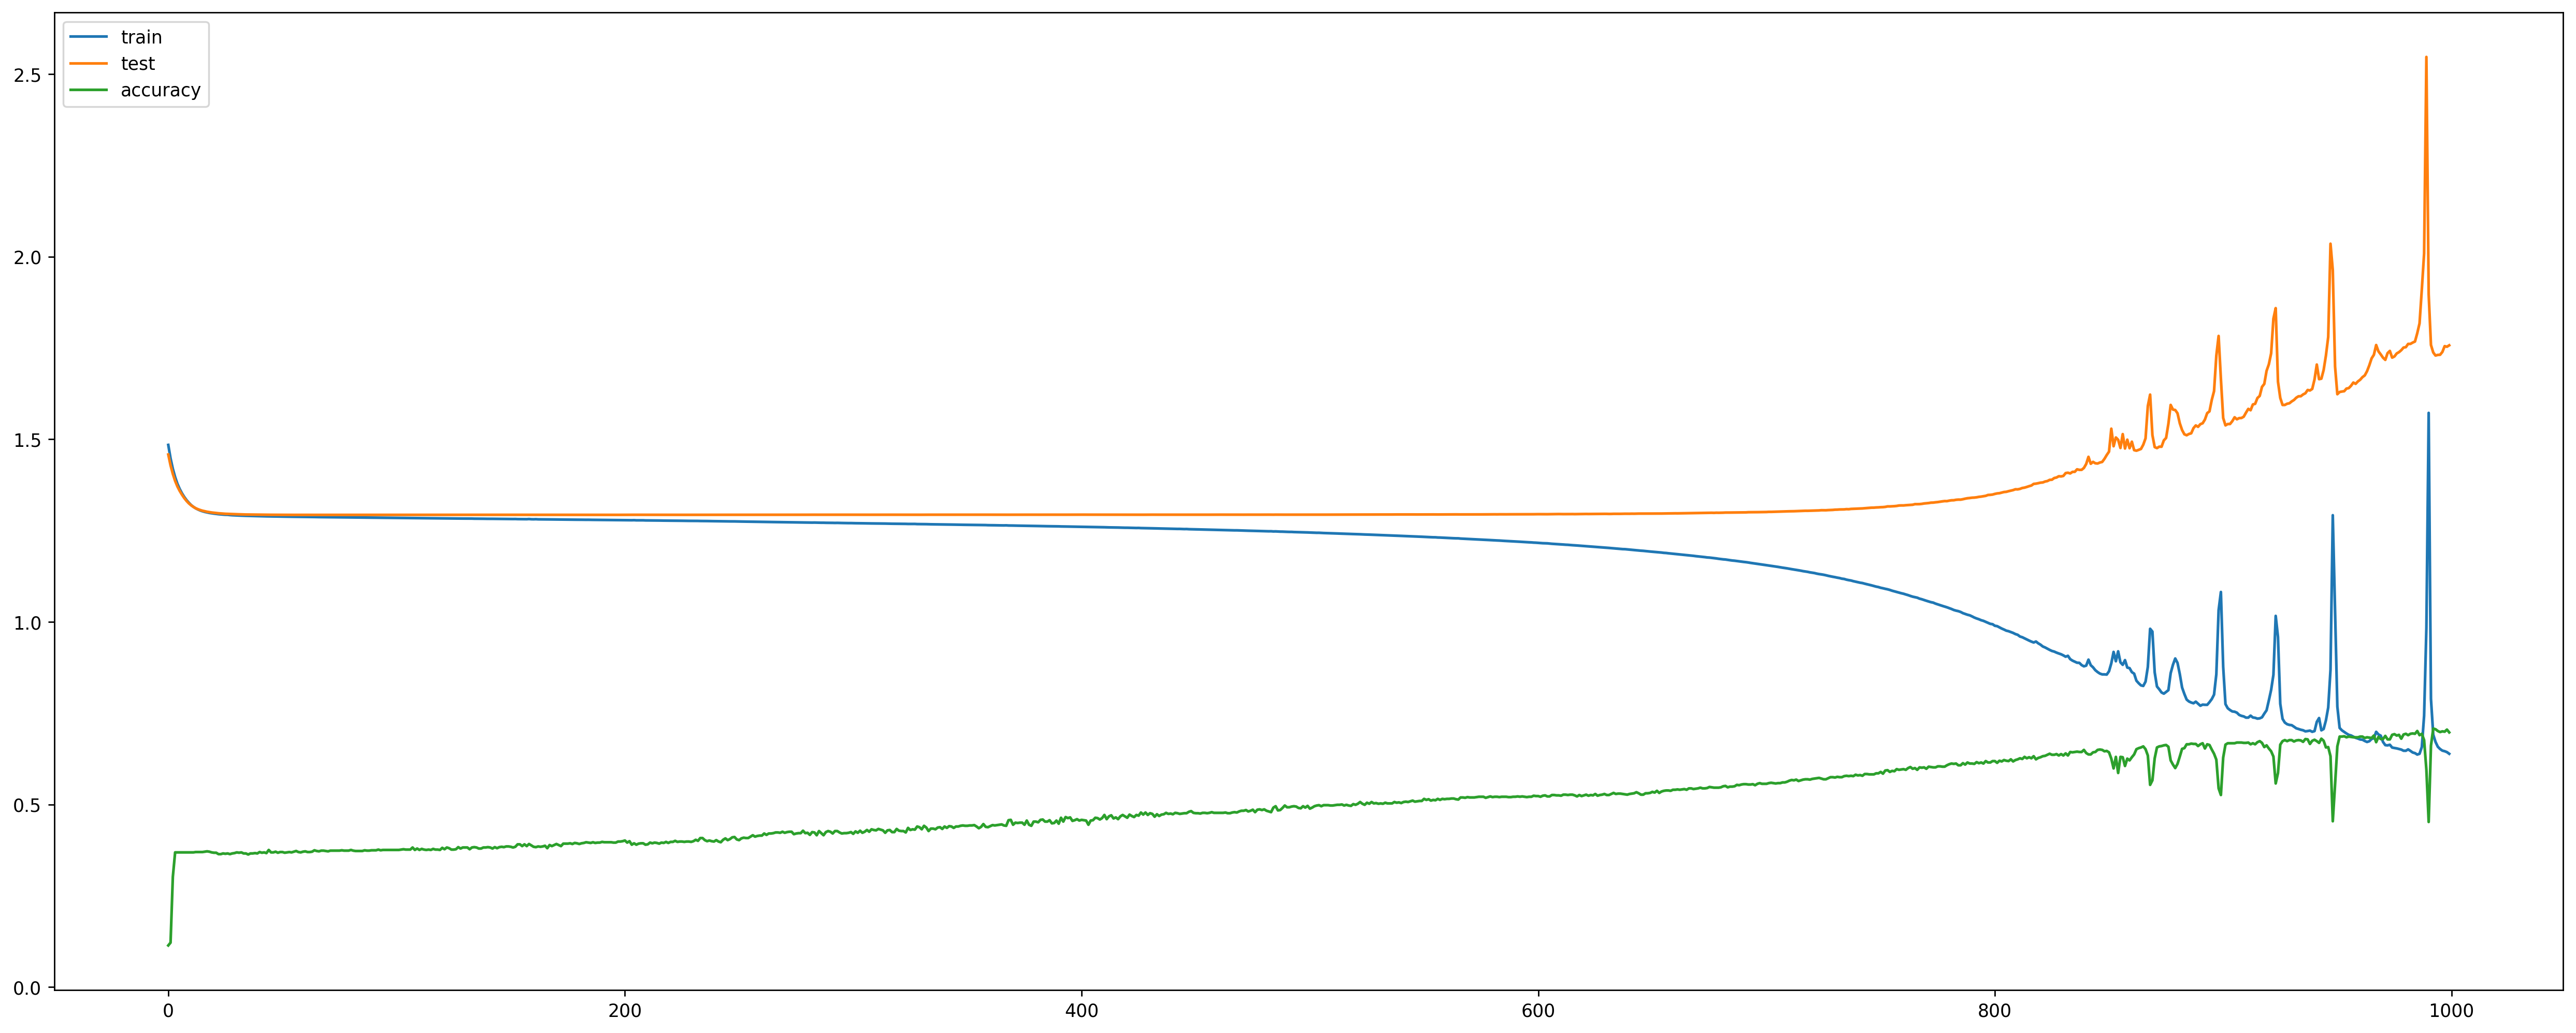

In [11]:
doStuff(files)

In [13]:
'hello'[1:]

'ello'

In [16]:
files

['OpenBCISession_2020-02-07_10-42-36-FOUR.2',
 'OpenBCISession_2020-02-23_16-49-310-VIR',
 'OpenBCISession_2020-02-06_12-08-05-THREE',
 'OpenBCISession_2020-02-29_17-51-57-BAHAR',
 'OpenBCISession_2020-02-07_11-12-39-FIVE',
 'OpenBCISession_2020-02-14_11-09-00-SEVEN',
 'OpenBCISession_2020-02-10_10-55-19=ONE.2',
 'OpenBCISession_2020-02-29_17-19-28-ELI',
 'OpenBCISession_2020-02-14_11-43-46-EIGHT',
 'OpenBCISession_2020-02-23_18-14-52-ISH',
 'OpenBCISession_2020-02-07_12-09-54-SIX',
 'OpenBCISession_2020-02-06_11-26-48-TWO']

In [14]:
files=files[1:]

In [15]:
for file in files:
    doStuff(file)

Doing O


FileNotFoundError: [Errno 2] No such file or directory: 'pickled-filt/O'

In [ ]:
# !~/gdrive-linux-x64 upload -r --parent 1vhs7zre7sOnRuWLeVT_sL7SMQpfFnrkx ~/pench/modelsv2/

In [ ]:
# make a prediction
yhat = model.predict(np.array(test_X))
np.set_printoptions(precision=8)
np.set_printoptions(suppress=True)

print(yhat)

In [ ]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [8]:
data=pickle.load(open('pickled-filt/'+'OpenBCISession_2020-02-06_11-26-48-TWO', 'rb'))

In [35]:
list(data[0][19].values())[0:-1]

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [37]:
data[0][20]

'sync'

In [15]:
', '.join(str(x) for x in data[0][0:18])

'113, -24.54, -28.3, -17.26, -21.41, -20.88, -23.09, -26.49, -19.96, -19.67, -19.83, -28.1, -25.62, -21.77, -25.44, -17.79, -18.08, 480'